<a href="https://colab.research.google.com/github/ChacoGolden/DSML_EV/blob/main/Train_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
# Load your datasets (use your own file paths in Colab)
no2_df = pd.read_csv("https://raw.githubusercontent.com/ChacoGolden/DSML_EV/refs/heads/main/No2_emissions_CH.csv")
ev_df = pd.read_csv("https://raw.githubusercontent.com/ChacoGolden/DSML_EV/refs/heads/main/CH_vehicles_ev_percentage.csv")

# Train-Test with only EV% and NO2

Linear regression

MSE: 21.70488488133021
MAE: 4.274564180075875
R² Score: 0.45870945271307084


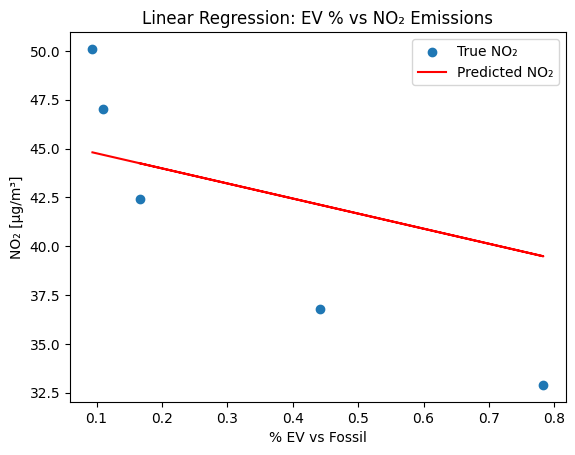

In [9]:
# Prepare your data
# Transpose the EV dataset
ev_df_t = ev_df.set_index('fuel_type').T.reset_index()
ev_df_t.rename(columns={'index': 'year', '% EV vs Fossil': 'ev_percent'}, inplace=True)
ev_df_t['year'] = ev_df_t['year'].astype(int)

# Clean and rename NO2 data
no2_df.rename(columns={'date': 'year', 'NO2 [ug/m3]': 'no2'}, inplace=True)

# Merge datasets
df = pd.merge(no2_df, ev_df_t[['year', 'ev_percent']], on='year')

# Define X and y
X = df[['ev_percent']]
y = df[['no2']]

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# Optional: visualize results
import matplotlib.pyplot as plt
plt.scatter(X_test, y_test, label='True NO₂')
plt.plot(X_test, y_pred, color='red', label='Predicted NO₂')
plt.xlabel('% EV vs Fossil')
plt.ylabel('NO₂ [μg/m³]')
plt.title('Linear Regression: EV % vs NO₂ Emissions')
plt.legend()
plt.show()


In [6]:
ev_df_t.head()

fuel_type,year,Fossil,Electricity,ev_percent
0,1990,3773139.0,3690.0,0.097797
1,1991,3876153.0,4547.0,0.117307
2,1992,3930170.0,4811.0,0.122412
3,1993,3959734.0,4904.0,0.123847
4,1994,4029039.0,4889.0,0.121344


polynomial regression

MSE: 8.221050106267523
MAE: 2.637756946888504
R² Score: 0.7949781012143248


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


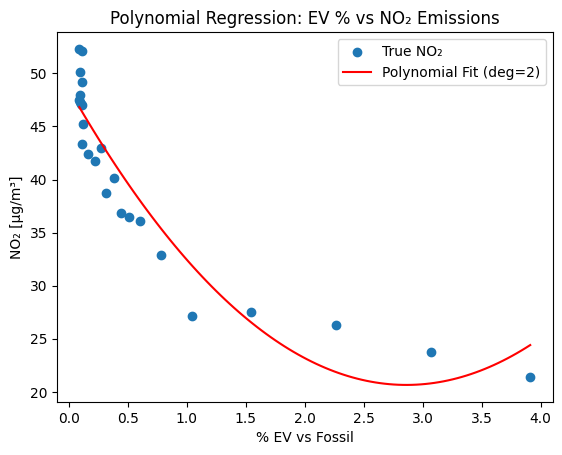

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1. Transpose and merge the data as before
ev_df_t = ev_df.set_index('fuel_type').T.reset_index()
ev_df_t.rename(columns={'index': 'year', '% EV vs Fossil': 'ev_percent'}, inplace=True)
ev_df_t['year'] = ev_df_t['year'].astype(int)

no2_df.rename(columns={'date': 'year', 'NO2 [ug/m3]': 'no2'}, inplace=True)

df = pd.merge(no2_df, ev_df_t[['year', 'ev_percent']], on='year')

# 2. Define X and y
X = df[['ev_percent']]
y = df[['no2']]

# 3. Transform features into polynomial (degree = 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# 4. Split the data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=0)

# 5. Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# 7. Plot the curve
import numpy as np
x_range = np.linspace(X['ev_percent'].min(), X['ev_percent'].max(), 100).reshape(-1, 1)
x_range_poly = poly.transform(x_range)
y_range_pred = model.predict(x_range_poly)

plt.scatter(X, y, label='True NO₂')
plt.plot(x_range, y_range_pred, color='red', label='Polynomial Fit (deg=2)')
plt.xlabel('% EV vs Fossil')
plt.ylabel('NO₂ [μg/m³]')
plt.title('Polynomial Regression: EV % vs NO₂ Emissions')
plt.legend()
plt.show()


# K-Fold cross-validation for the polynomial regression

In [12]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Use full data
X = df[['ev_percent']]
y = df[['no2']]

# Create polynomial regression pipeline (degree 2)
model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Define 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Run cross-validation for MSE
cv_mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
cv_r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

# Convert negative MSE to positive
mse_scores = -cv_mse_scores

# Print results
print("MSE scores (per fold):", mse_scores)
print("Average MSE:", np.mean(mse_scores))
print("R² scores (per fold):", cv_r2_scores)
print("Average R²:", np.mean(cv_r2_scores))


MSE scores (per fold): [ 9.83314861 14.00877525  9.55374806 61.77801534 10.83407514]
Average MSE: 21.201552478048676
R² scores (per fold): [ 0.88190396  0.79446737  0.49858567 -0.84205236  0.76607141]
Average R²: 0.41979520965432987
